In [20]:
import torch
import numpy as np

train_on_gpu=torch.cuda.is_available()
print(train_on_gpu)


True


Load the Data

In [21]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

number_of_workers = 0 # stand for number of subprocesses to use for data loading
batch_size= 10 # stand for how many samples per batch to load
valid_size= 0.2 # stand for percentage of training set to use as validation 

#  Set several methods in the transforms module to prepare the data for training.
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])
# 先随机水平翻转图像，这有助于模型学习不依赖于图像的方向。
# 随机旋转图像最多10度，增加训练数据的多样性。
# 将图像数据转换为PyTorch张量。
# 对图像数据进行归一化处理，设置每个颜色通道的平均值和标准差。

In [22]:
# Downloading training and testing Datasets
train_data= datasets.CIFAR10('data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform= transform)

print("Number of training examples: ", len(train_data))
print("Number of testing examples: ", len(test_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples:  50000
Number of testing examples:  10000


In [23]:
# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
# 随机打乱索引列表的顺序。这一步骤是为了确保数据的随机性，避免因数据顺序可能带来的偏差。
np.random.shuffle(indices)
# 表示用于验证的数据占总训练数据的比例
split = int(np.floor(valid_size * num_train))
print(split)
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]
print(len(train_idx), len(valid_idx))

10000
40000 10000


In [24]:
# 创建一个采样器来从训练数据中随机抽取样本，这里使用的索引是train_idx，即之前确定的训练集索引。
train_sampler = SubsetRandomSampler(train_idx)
# 创建一个采样器来从验证数据中随机抽取样本，这里使用的索引是valid_idx，即之前确定的验证集索引。
valid_sampler = SubsetRandomSampler(valid_idx)

In [25]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size, 
                                         num_workers= number_of_workers)

# train_sampler 用于确定如何从训练数据集中选择样本，而 train_loader 则用于实际加载这些样本，将它们组织成批次，以供模型训练使用。

In [26]:
# After preparing Data, we have to unnormalize it to visullize it.
# Lets create a helper function which will un-normalize all the images
import matplotlib.pyplot as plt

def imshow(img):
  # Will take numpy array as input
  
  # 对图像进行反归一化。在训练模型时，图像数据通常会被归一化（比如将像素值从[0, 255]缩放到[-1, 1]范围）。这里的操作是将归一化后的图像数据转换回原始的像素值范围。这是为了使图像能以正确的形式显示。
  img = img / 2 + 0.5
  
  # 用于显示图像。在PyTorch中，图像通常以[通道, 高度, 宽度]的格式存储，而matplotlib期望图像以[高度, 宽度, 通道]的格式。因此，需要使用np.transpose(img, (1, 2, 0))来改变图像数组的维度顺序。这个操作将通道维度移动到最后，从而使图像的格式与matplotlib兼容。
  plt.imshow(np.transpose(img, (1, 2, 0)))

In [27]:
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([10, 3, 32, 32])


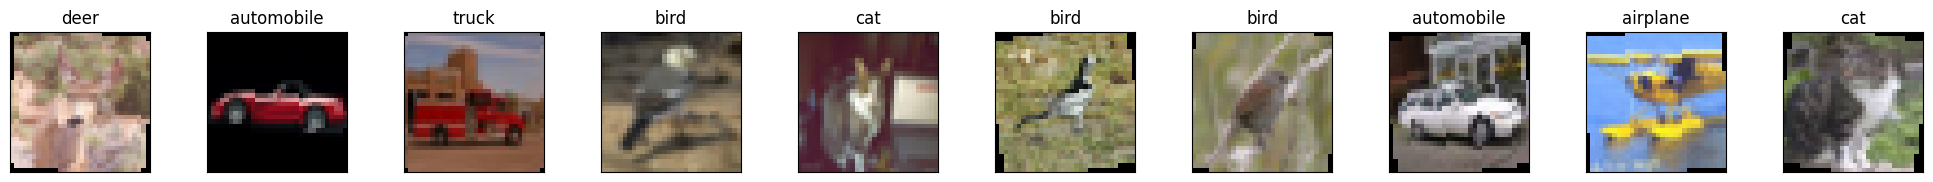

In [28]:
# 创建一个迭代器dataiter，用于逐批次遍历train_loader中的数据。
dataiter = iter(train_loader)

# 使用next()函数从dataiter中获取下一批数据。这里images和labels分别代表了图像数据和对应的标签。
images, labels = next(dataiter)
print(images.shape)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(10):
  ax= fig.add_subplot(2 , 10 , idx+1 , xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])
  
# 在 train_loader 中，图像数据和标签确实是一起存储的，但它们的格式是不同的。详细来说：
#
# 图像数据: 
# 图像数据是以张量（tensor）的形式存储的。在大多数情况下，这些张量是多维的，具体维度取决于图像的特征。对于彩色图像（如CIFAR-10数据集），每张图像通常以三维张量表示，维度为 [channels, height, width]（例如，对于32x32像素的RGB图像，其维度为 [3, 32, 32]）。
# 在 DataLoader 返回的批次中，这些图像张量会被组合成一个更大的张量，其形状通常是 [batch_size, channels, height, width]。例如，如果批量大小为20，则一批图像的张量形状将是 [20, 3, 32, 32]。
# 
# 标签:
# 标签是以一维张量的形式存储的，每个元素代表对应图像的类别。这些标签通常是整数形式，表示类别的索引。
# 对于每个批次batch，标签张量的长度等于批量大小。例如，如果批量大小为20，则标签张量的形状将是 [20]。
# "每个位置上的值对应于该批次中相应图像的类别。"
# 综上所述，train_loader 中的每个元素实际上是一个包含两部分的元组：一个是图像数据张量，另一个是标签张量。它们被一起加载和返回，但在格式和用途上有所不同。图像数据用于模型的输入，而标签数据用于训练过程中的比较和损失计算。

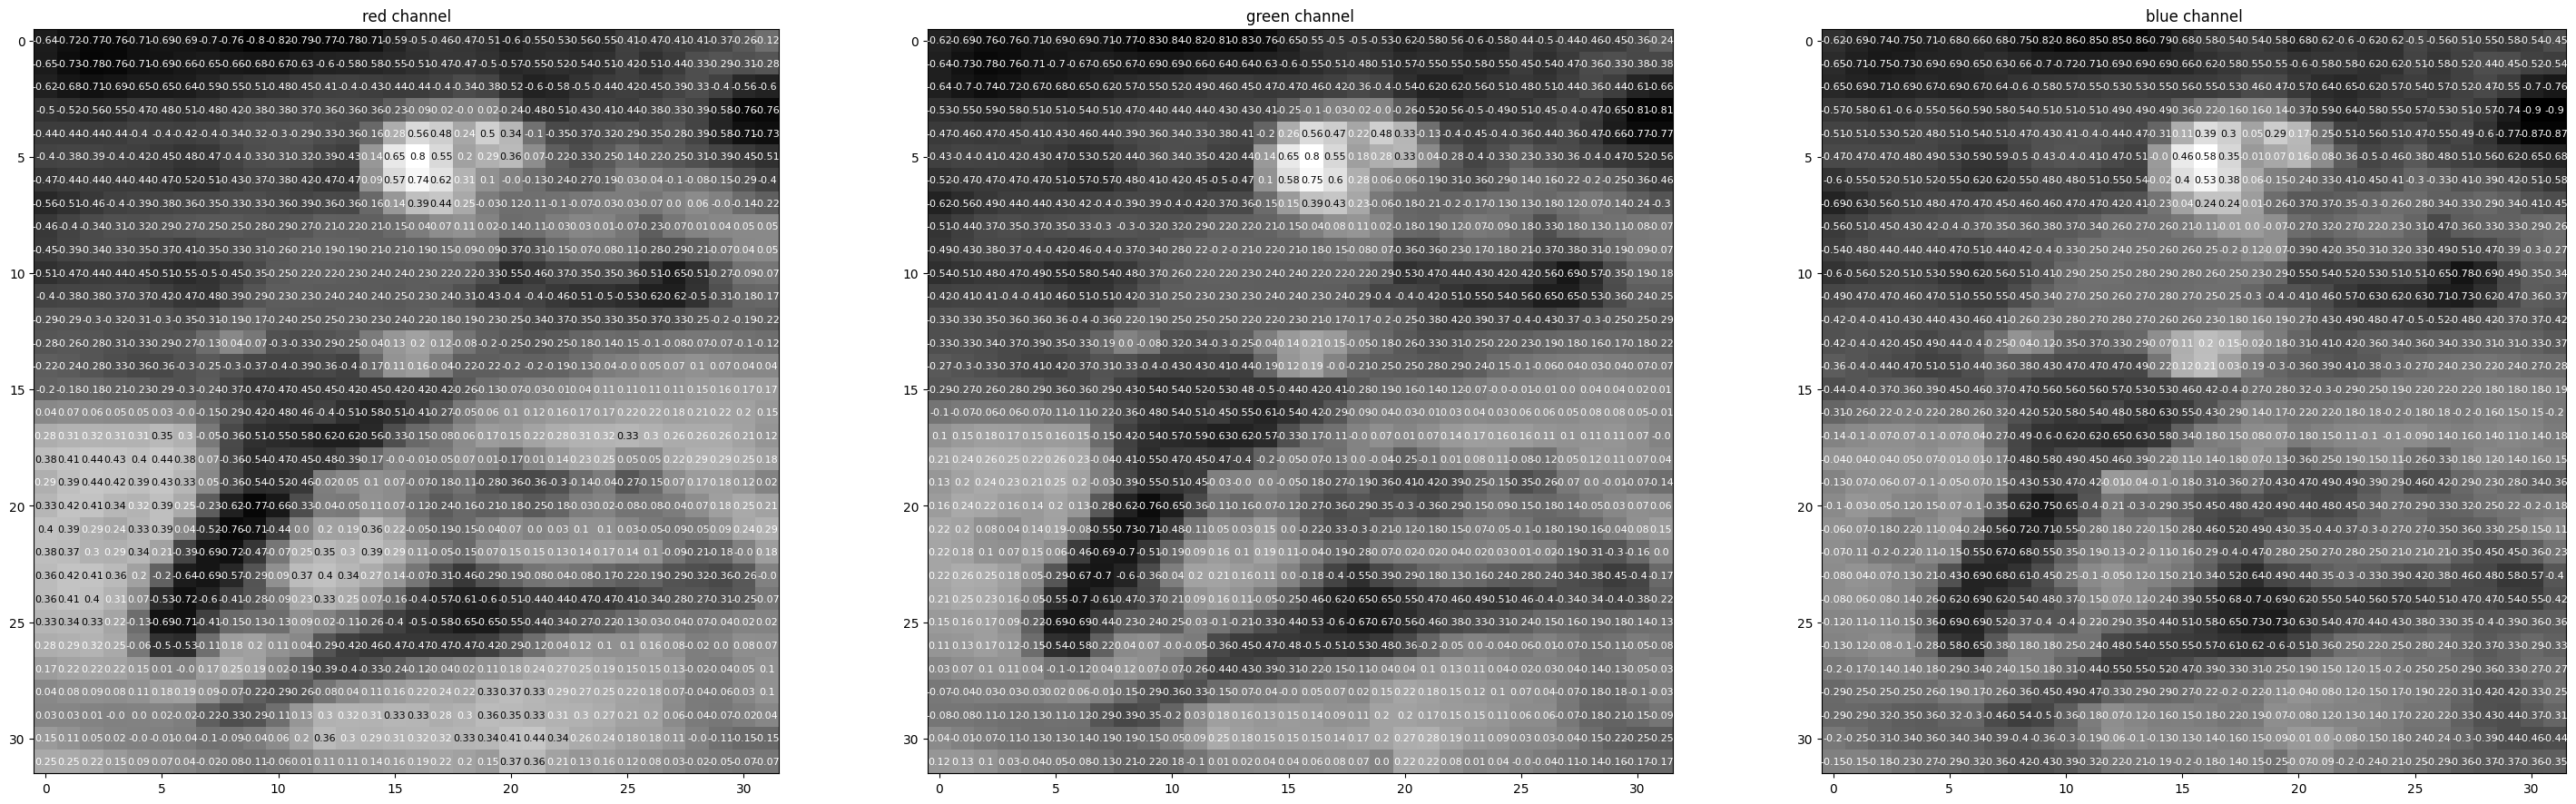

In [29]:
# 可视化一个RGB图像的每个颜色通道，并在每个通道图像上标注像素值。
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        # 表示一个卷积层，输入通道为3（如RGB图像），输出通道为6，卷积核大小为2x2，填充（padding）为1，步长（stride）为1。
        self.conv1 = nn.Conv2d(3, 6, 2 , padding=1, stride= 1) # (32 - 5+ 2(0) / 1) + 1 = 28
        self.pool1 = nn.MaxPool2d(2, 2) # (28 - 2 + 2(0)/ 2) + 1 = 14
        self.conv2 = nn.Conv2d(6, 16, 2, padding=1, stride= 1) # (14 - 5 + 2(0)/ 1) + 1 = 10
        
        self.pool2 = nn.MaxPool2d(2, 2) # (10 - 2 + 2(0)/ 2) + 1 = 5
        self.conv3 = nn.Conv2d(16, 32, 2)# (5 - 2 + 2(0)/ 1) + 1 = 4
        self.pool3 = nn.MaxPool2d(2, 2)# (4 - 2 + 2(0)/ 2) + 1 = 2
        
        self.fc1 = nn.Linear(32* 3**2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool1( F.relu(self.conv1(x)))
        x= self.pool2( F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
        # Flatten it
        x= torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    print("Model moved to GPU")
else:
    print("Model is on CPU")

Net(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Model moved to GPU


In [31]:
def feature_calc(num_channels, k_size, stride , pad):
  calc_result=( ((num_channels - k_size + 2*pad ) / stride) + 1)
  return calc_result

In [32]:
a1=feature_calc(32, 2, 1, 1)
a2=feature_calc(np.floor(a1), 2, 2, 0)
a3=feature_calc(np.floor(a2), 2, 1, 1)
a4= feature_calc(np.floor(a3), 2, 2, 0)
a5= feature_calc(np.floor(a4), 2, 1, 0)
a6= feature_calc(np.floor(a5), 2, 2, 0)

print(a1, a2, a3, a4, a5, a6)

33.0 16.5 17.0 8.5 7.0 3.5


In [33]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr= 0.0001, momentum= 0.9)

In [34]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.842423 	Validation Loss: 0.460536
Validation loss decreased (inf --> 0.460536).  Saving model ...
Epoch: 2 	Training Loss: 1.841027 	Validation Loss: 0.460186
Validation loss decreased (0.460536 --> 0.460186).  Saving model ...
Epoch: 3 	Training Loss: 1.839545 	Validation Loss: 0.459674
Validation loss decreased (0.460186 --> 0.459674).  Saving model ...
Epoch: 4 	Training Loss: 1.836421 	Validation Loss: 0.458419
Validation loss decreased (0.459674 --> 0.458419).  Saving model ...
Epoch: 5 	Training Loss: 1.827978 	Validation Loss: 0.454726
Validation loss decreased (0.458419 --> 0.454726).  Saving model ...
Epoch: 6 	Training Loss: 1.794452 	Validation Loss: 0.438633
Validation loss decreased (0.454726 --> 0.438633).  Saving model ...
Epoch: 7 	Training Loss: 1.712339 	Validation Loss: 0.418077
Validation loss decreased (0.438633 --> 0.418077).  Saving model ...
Epoch: 8 	Training Loss: 1.654277 	Validation Loss: 0.409480
Validation loss decreased (0.41807

In [17]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [18]:
from torch import classes

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.418160

Test Accuracy of airplane: 48% (486/1000)
Test Accuracy of automobile: 54% (546/1000)
Test Accuracy of  bird: 38% (380/1000)
Test Accuracy of   cat: 35% (358/1000)
Test Accuracy of  deer: 33% (338/1000)
Test Accuracy of   dog: 39% (396/1000)
Test Accuracy of  frog: 60% (603/1000)
Test Accuracy of horse: 57% (578/1000)
Test Accuracy of  ship: 59% (599/1000)
Test Accuracy of truck: 58% (589/1000)

Test Accuracy (Overall): 48% (4873/10000)


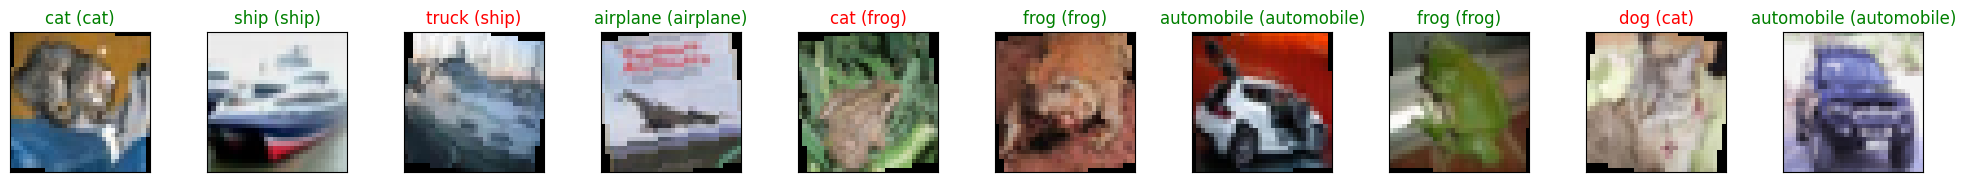

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))